In [18]:
import numpy as np
from river.drift import ADWIN

class Node:
    def __init__(self, is_leaf=True, prediction=None, is_alternate=False, parent=None, path=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.split_feature = None
        self.split_value = None
        self.children = {}
        self.class_counts = np.zeros(2)
        self.adwin = ADWIN()
        self.alternate_tree = None
        self.n_predictions = 0
        self.n_correct_predictions = 0
        self.data_batch = []
        self.label_batch = []
        self.parent = parent
        self.path = []
        self.is_alternate = is_alternate

    @property
    def accuracy(self):
        if self.n_predictions == 0:
            return 0
        return self.n_correct_predictions / self.n_predictions

def hoeffding_bound(R, n):
    return np.sqrt((R**2 * np.log(1/0.10)) / (2 * n))

def entropy(labels):
    # Count the occurrences of each class
    label_counts = np.bincount(labels, minlength=2)
    
    # Calculate the probabilities for each class
    probabilities = label_counts / np.sum(label_counts)
    
    # Remove probabilities equal to 0 for log2 calculation
    probabilities = probabilities[probabilities > 0]
    
    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy 

def information_gain(parent_labels, left_labels, right_labels):
    # Entropy before the split
    entropy_before = entropy(parent_labels)
    
    # Weighted entropy after the split
    total_size = len(parent_labels)
    left_size = len(left_labels)
    right_size = len(right_labels)
    
    weighted_entropy = (left_size / total_size) * entropy(left_labels) + \
                        (right_size / total_size) * entropy(right_labels)

    # Information gain is the reduction in entropy
    return entropy_before - weighted_entropy

def best_split(data, labels):
    features = data.shape[1]
    best_info = {'feature': None, 'value': None, 'info_gain': -np.inf}
    second_best_info = {'feature': None, 'value': None, 'info_gain': -np.inf}
    
    # Iterate though all the features
    for feature in range(features):
        values = np.sort(np.unique(data[:, feature]))
        values_n = len(values) - 1
        
        # Sort through the unique values
        for i in range(values_n):
            split_value = (values[i] + values[i+1]) / 2
            
            # Mark the values with lower than the split
            smaller_values = data[:, feature] <= split_value
            #Negation fo the left
            bigger_values = ~smaller_values
            
            # Calculate Information Gain
            info_gain = information_gain(labels, labels[smaller_values], labels[bigger_values])
            if info_gain > best_info['info_gain']:
                best_info, second_best_info = {
                    'feature': feature,
                    'value': split_value,
                    'info_gain': info_gain
                }, best_info
                
    return best_info, second_best_info

class HAT:
    def __init__(self, batch_size=50):
        self.root = Node(is_leaf=True, prediction=0)
        self.alt_trees = 0
        self.pruned_trees = 0
        self.batch_size = batch_size

    def HATGrow(self, x, y, node=None):
        # If node is None, start from root
        if node == None:
            node = self.root
        # While node is not a leaf, traverse the tree and check for alternate trees. If there is an alternate tree, pass it the data stream and grow it as well
        while not node.is_leaf:
            if x[node.split_feature] <= node.split_value:
                if node.alternate_tree:
                    self.HATGrow(x, y, node.alternate_tree)
                if node.is_leaf:
                    break
                node = node.children['left']
            else:
                if node.alternate_tree:
                    self.HATGrow(x, y, node.alternate_tree)
                if node.is_leaf:
                    break
                node = node.children['right']

        # Update the data_batch and label_batch of the node for best_split calculations later
        node.data_batch.append(x)
        node.label_batch.append(y)

        # Update that class counts and prediction of the leaf node
        correct = False
        node.class_counts[y] += 1
        node.prediction = np.argmax(node.class_counts)
        if node.prediction == y:
            correct = True
        node.n_predictions = np.sum(node.class_counts)
        node.n_correct_predictions = np.max(node.class_counts)

        # Update the accuracy of each node from the root to the leaf it got classified at
        self.update_whole_tree_accuracy(node, correct, y)

        # Split the node if the data_batch size is reached
        if len(node.data_batch) >= self.batch_size:  
            self._attempt_to_split(node)
        
        if node.parent:
            # For each node in the nodes path, update the estimators (ADWIN)
            for nodeX in node.path:
                nodeX.adwin.update(1 if y != nodeX.prediction else 0)
                # If drift is detected, create an alternate tree if there is not already one for that node and the node isnt an alternate itself.
                if nodeX.adwin.drift_detected:
                    # If there is no alternate tree and the node is not a part of the alternate tree itself, create a alternate tree and recursively grow it.
                    if nodeX.alternate_tree is None and not nodeX.is_alternate:
                        self.alt_trees += 1
                        node.alternate_tree = Node(is_leaf=True, prediction=np.argmax(node.class_counts), is_alternate=True, parent=node.parent)
                        self.HATGrow(x, y, node.alternate_tree)
                        continue
                
                self.possibly_replace(nodeX)
    
    def possibly_replace(self, node):
        if node.alternate_tree:
            main_tree_accuracy = node.accuracy()
            alt_tree_accuracy = node.alternate_tree.accuracy()
            if alt_tree_accuracy > main_tree_accuracy:
                self.pruned_trees += 1
                node.is_leaf = node.alternate_tree.is_leaf
                node.split_feature = node.alternate_tree.split_feature
                node.split_value = node.alternate_tree.split_value
                node.children = node.alternate_tree.children
                node.n_correct_predictions = node.alternate_tree.n_correct_predictions
                node.n_predictions = node.alternate_tree.n_predictions
                self.update_is_alternate_status(node.children)

    def update_is_alternate_status(self, children):
        for child in children.values():
            child.is_alternate = False
            self.update_is_alternate_status(child.children)

            
    # This method updates the accuracy of each node in the path that a piece of data followed down.
    # If the piece of data is classified correctly, the accuracy increases.
    def update_whole_tree_accuracy(self, node, correct, y):
        for x in node.path:
            x.class_counts[y] += 1
            x.prediction = np.argmax(x.class_counts)
            x.n_predictions += 1
            if correct:
                x.n_correct_predictions += 1
            x.accuracy = x.n_correct_predictions / x.n_predictions

    # Attempt to split the node
    def _attempt_to_split(self, node):
        X_sub = np.array(node.data_batch)
        y_sub = np.array(node.label_batch)
        
        best_info, second_best_info = best_split(X_sub, y_sub)
        if best_info['feature'] is not None: 
            n = np.sum(node.class_counts)
            epsilon = hoeffding_bound(1, n)
            
            # Check if the split is significant
            if best_info['info_gain'] - second_best_info['info_gain'] > epsilon:
                newPath = node.path.copy()
                newPath.append(node)
                node.is_leaf = False
                node.split_feature = best_info['feature']
                node.split_value = best_info['value']
                # Set leaf to True, inherit parent's prediction, set parent to the node, have leaf inherit parents alternate tree status
                # give children node's path plus itself
                node.children['left'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts), parent=node,
                                              is_alternate=node.is_alternate, path=newPath )
                node.children['right'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts), parent=node, 
                                              is_alternate=node.is_alternate, path=newPath)
                # The nodes accuracy is set to 0, and the accuracy of all nodes above it must be recalculated.
                # This makes it a true accuracy calculation with a datastream because the accuracy of the tree and node will change with
                # splits and classifying a new piece of data
                self.split_accuracy_recalc(node)

        node.data_batch = []
        node.label_batch = []

    # Recalculate the accuracy of each node in the tree based after splitting a node
    def split_accuracy_recalc(self, node):
        predictions = node.n_predictions
        correct_prediction = node.n_correct_predictions
        class_counts = node.class_counts
        for x in node.path:
            x.n_predctions -= predictions
            x.n_correct_predictions -= correct_prediction
            x.prediction -= class_counts
        node.n_predictions = 0
        node.n_correct_predictions = 0
        node.class_counts = np.zeros(2)
            
    # Predict where the data is going
    def predict(self, x):
        node = self.root
        while not node.is_leaf:
            if x[node.split_feature] <= node.split_value:
                node = node.children['left']
            else:
                node = node.children['right']

        pred = node.prediction
        return pred

In [19]:
file_path = 'Skin_NonSkin 2.txt'

# Load the data
data = np.loadtxt(file_path, delimiter='\t')

# Split the data into features and target variable
X = data[:, :-1]
y = data[:, -1].astype(int) 
y = y - 1

In [20]:
model = HAT()

errors_count = 0
error_rates = []

for i in range(len(y)):
    pred = model.predict(X[i])

    if pred != y[i]:
        errors_count += 1
        
    # Calculate Error Rate
    if i > 10000:
        error_rate = errors_count / (i + 1)
        error_rates.append([i, error_rate])
    
    # Print Every 10000 Iterations
    if i % 10000 == 0:
        print(f'Instance: {i}')
    
    model.HATGrow(X[i], y[i])
print(model.pruned_trees)
print(model.alt_trees)

Instance: 0
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X
X


KeyboardInterrupt: 

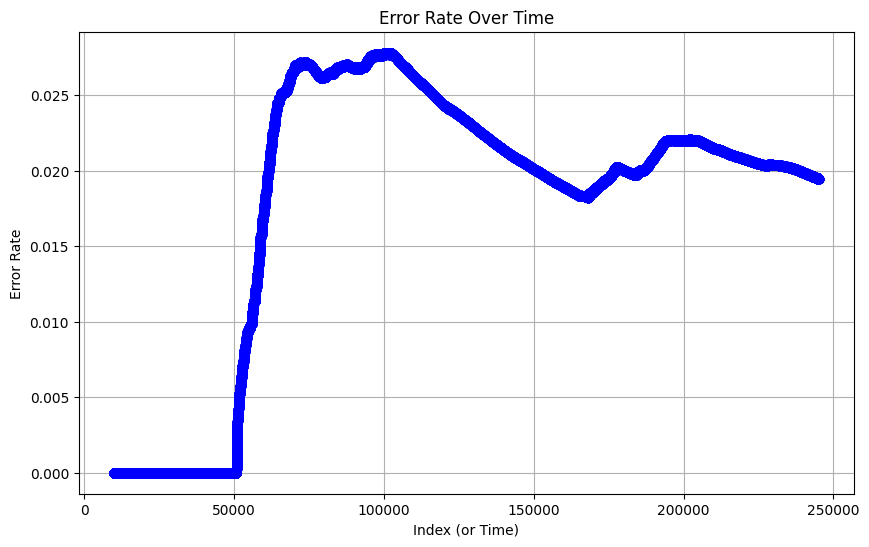

In [ ]:
import matplotlib.pyplot as plt

idxs, errors = zip(*error_rates)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(idxs, errors, marker='o', linestyle='-', color='b')  # Marker, linestyle, and color are optional
plt.title('Error Rate Over Time')
plt.xlabel('Index (or Time)')
plt.ylabel('Error Rate')
plt.grid(True)  # Optional: Adds a grid for easier reading
plt.show()